## Predicting Property Values

Oliver Ton - 03.30.2022

### Executive Summary

The goal of this project is to acquire Zillow regarding single unit porperty values from 2017, cleaning and analyzing it to create supervised machine learning models. These models were used to predict property tax values of single unit properties.

### Project Overview

- Python scripts were used to automate the process of acquiring, preparing and explorign the data
- The data was cleaned by replacing null values, dropping duplicates, encoding new features and one hot encoding features
    - These steps were taken to create the best performing model (mvp)
    - Outliers in the data were analyzed as weel as the distributions of variables explored in depth 
- The data was split into train, validate and test into 3 dataframes beofre modeling to avoid data leakage and maintain data integrity 
- Recursive feature engineering was utilized to select the top features to be included in the models used to predict property values
- The target variables, tax value, is continuous, used the following regression algorithms to create models that perform better than the baseline:
    - OLS Linear Regression
    - Lasso + Lars
    - Tweedie Regressor GLM
    - Polynomial Regression
- The best model (mvp) was fitted on the test data to predict propter values

In [1]:
#Import
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

import wrangle as w
import evaluate as eva
import explore as exp
import model as m

## Wrangle

In [2]:
#Data acquire from Codeup database and then return Zillow data into a dataframe and create a csv 
df = w.get_zillow_data()

In [3]:
#Checking if the function above run as intended 
df.head()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips,taxamount
0,14372057,2.0,2.5,1348.0,343967.0,1979.0,6059.0,3628.14
1,13929199,3.0,2.0,1221.0,367034.0,1955.0,6059.0,4589.60
2,12430095,3.0,2.0,1462.0,79713.0,1950.0,6037.0,1269.65
3,13033318,2.0,1.0,768.0,270458.0,1926.0,6037.0,3373.09
4,12079615,4.0,4.0,3696.0,940251.0,1989.0,6037.0,10313.18


In [4]:
#Checking for null values
w.miss_dup_values(df)

Your selected dataframe has 8 columns.
There are 4 columns that have missing values.
  
** There are 121 duplicate rows that represents 0.23% of total Values**


,Missing Values,% of Total Values
yearbuilt,116,0.2
calculatedfinishedsquarefeet,82,0.2
taxamount,4,0.0
taxvaluedollarcnt,1,0.0


In [5]:
#Clean zillow data: rename columns, drop any duplicates and null values
df = w.clean_zillow(df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52196 entries, 0 to 52440
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   parcel_id        52196 non-null  object 
 1   number_bedroom   52196 non-null  float64
 2   number_bathroom  52196 non-null  float64
 3   sqft             52196 non-null  float64
 4   tax_value        52196 non-null  float64
 5   geographic_code  52196 non-null  int64  
 6   tax_amount       52196 non-null  float64
 7   age              52196 non-null  float64
 8   tax_rate         52196 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 4.0+ MB


In [7]:
#Checking again for null values
w.miss_dup_values(df)

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values


In [8]:
#Remove rows with outlier
df = w.remove_outlier(df)

In [9]:
#Split the data into 3 dataframes - train, validate and test
#Target variable - tax_value
target = 'tax_value'
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = w.split_data(df, target)

X_train -> (28840, 8)               y_train->(28840,)
X_validate -> (12360, 8)         y_validate->(12360,) 
X_test -> (10300, 8)                  y_test>(10300,)


## Explore

In [10]:
#Putting our features columns into a list
cols = ['sqft','number_bathroom','number_bedroom','geographic_code','age']

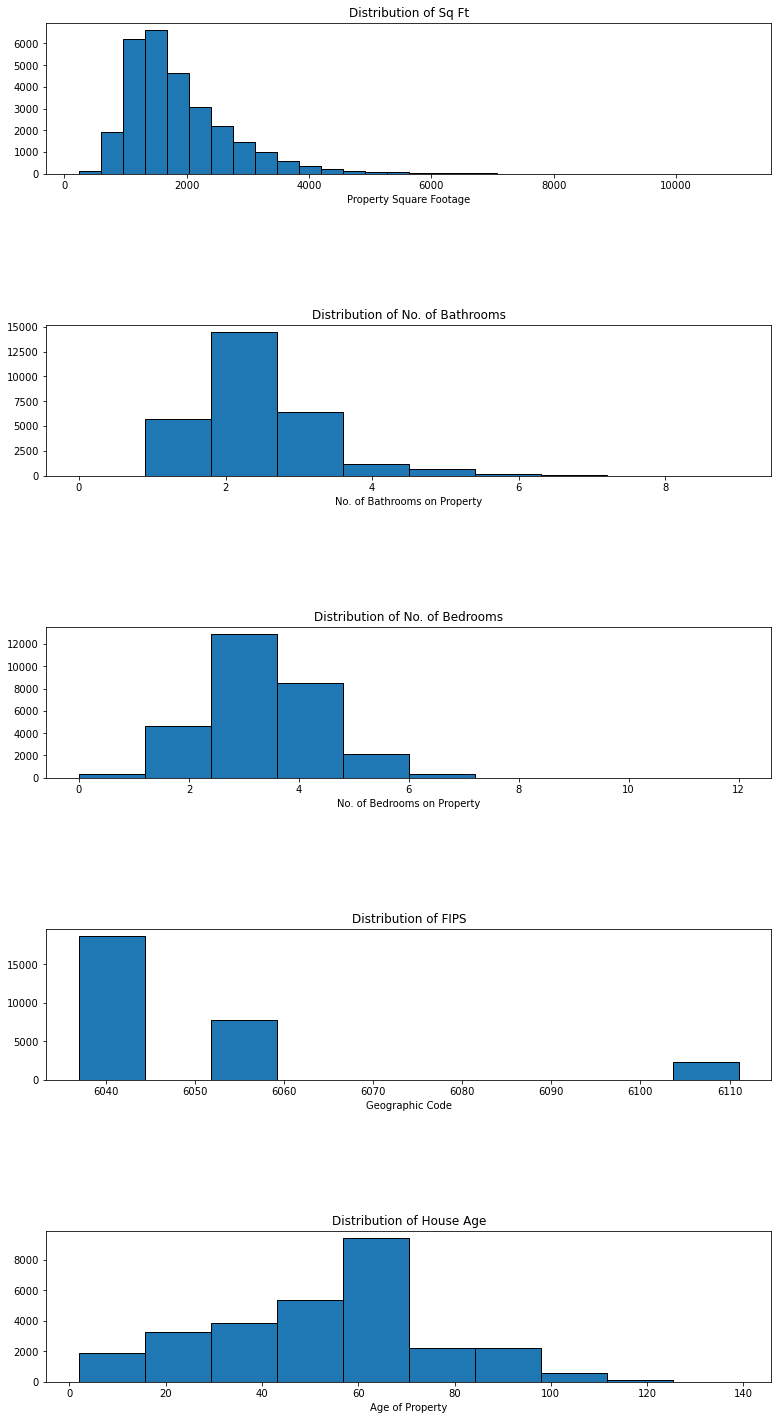

In [11]:
#Checking distributions of our selected features/univariate exploration
exp.distribution_plot(train,cols)

<AxesSubplot:title={'center':'Feautures Correlating with Value'}>

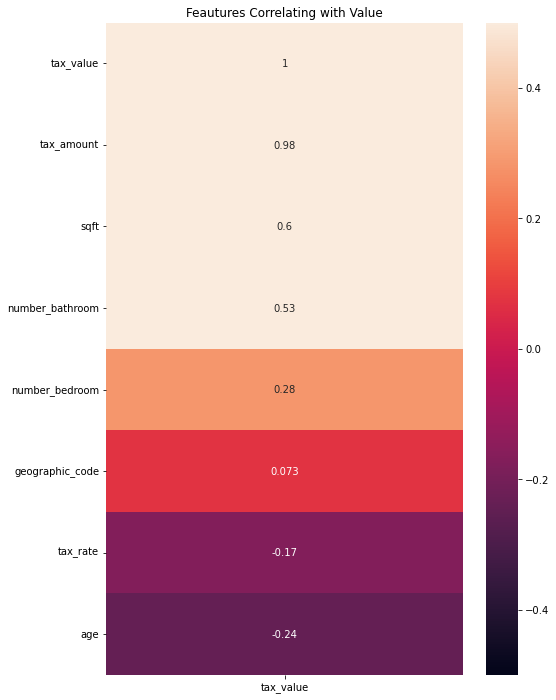

In [12]:
#Heatmap
exp.get_zillow_heatmap(train)

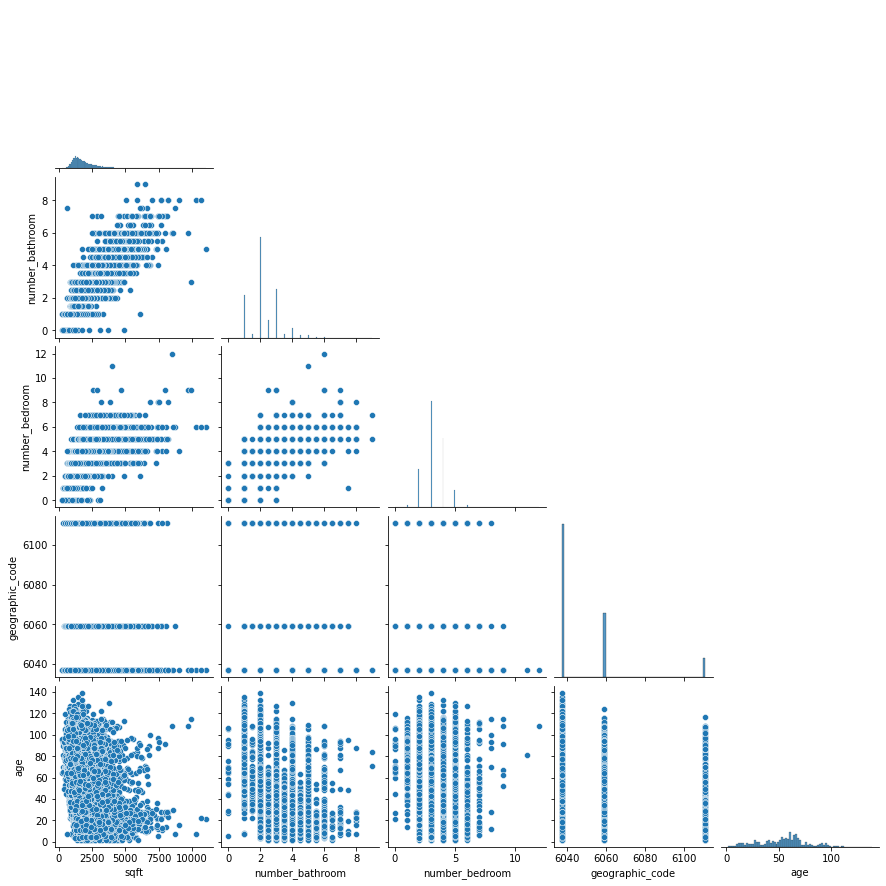

In [13]:
#Create a plots and histograms
exp.plot_pairplot(train, cols, hue=None)